# Variational Inference and SGHMC

The purpose of this notebook is to compare Variational Inference (VI) and Stochastic Gradient Hamiltonian Monte Carlo (SGHMC) is the MNIST Bayesian neural network (BNN) setting.

As a fair comparison we allow (VI) 50 epochs to learn the variational parameters of the BNN, we also give SGHMC 50 burn-in epochs so that it has hopefully reached the posterior distribution by this point (or at least found some good parameters). We then sample 80000 samples from the variational posterior and we (approximately) sample 80000 parameters from the true posterior using SGHMC.

We the compare the two sample sets using a 50000/10000 train/validation split.

In [1]:
import sys
sys.path.append("..")

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC

from pyro.infer import SVI, Trace_ELBO, RenyiELBO
from pyro.optim import SGD, Adam, ClippedAdam

pyro.set_rng_seed(101)

plt.rcParams['figure.dpi'] = 300

In [2]:
# Simple dataset wrapper class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### Hyperparams

In [3]:
BATCH_SIZE = 500
NUM_EPOCHS = 800
WARMUP_EPOCHS = 50
HIDDEN_SIZE = 100

### Download MNIST and setup datasets / dataloaders

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]
    
mean = 0.1307
std = 0.3081

# scale and normalise the datasets
X_train = (train_dataset.data[train_idx] / 255.0 - mean) / std
Y_train = train_dataset.targets[train_idx]

X_val = (train_dataset.data[val_idx] / 255.0 - mean) / std
Y_val = train_dataset.targets[val_idx]

X_test = (test_dataset.data / 255.0 - mean) / std
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Define the Bayesian neural network  model

In [5]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size, prec=1.):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting
        
        # TODO add gamma priors to precision terms
        self.fc1 = PyroLinear(input_size, hidden_size)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size]).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size, hidden_size]).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size]).to_event(1))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

### Run VI

We run VI using the RenyiELBO to get a tight variational bound, we use the ClippedAdam optimizer which implements weight decay, gradient clipping, and learning rate decay.

We run this for 50 epochs but typically the validation loss diverges and so we stop early if the validation loss ever decreases.

In [6]:
pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)
guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)

svi = SVI(model=bnn, 
          guide=guide, 
          optim=ClippedAdam({"lr": 1e-3, "weight_decay": 1e-3, "clip_norm": 1.0}), 
          loss=RenyiELBO(alpha=0.01, num_particles=2))

num_epochs = WARMUP_EPOCHS
epoch = 0

normalizer = len(train_loader.dataset)

test_acc = [0.0]

while epoch < num_epochs:
    losses = []
    for imgs, labels in train_loader:
        total_loss = svi.step(imgs, labels)
        loss = total_loss / normalizer
        losses += [loss]
        
    epoch += 1
        
    print('Epoch {} avg loss {:.4f}'.format(epoch, np.mean(losses)))
    
    predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=100)

    with torch.no_grad():
        total = 0
        correct = 0
        for imgs, labels in val_loader:
            out = predictive(imgs)
            pred = out['obs'].mode(0)[0]
            total += labels.shape[0]
            correct += int((pred == labels).sum())

        print("test accuracy:",correct/ total)
        
        if (correct / total) < test_acc[-1]:
            break
        else:
            test_acc.append(correct/total)
            continue

Epoch 1 avg loss 2.9783
test accuracy: 0.7882
Epoch 2 avg loss 2.7689
test accuracy: 0.8629
Epoch 3 avg loss 2.6098
test accuracy: 0.8945
Epoch 4 avg loss 2.4557
test accuracy: 0.9096
Epoch 5 avg loss 2.3043
test accuracy: 0.9235
Epoch 6 avg loss 2.1589
test accuracy: 0.9255
Epoch 7 avg loss 2.0173
test accuracy: 0.9315
Epoch 8 avg loss 1.8805
test accuracy: 0.934
Epoch 9 avg loss 1.7484
test accuracy: 0.9344
Epoch 10 avg loss 1.6218
test accuracy: 0.9366
Epoch 11 avg loss 1.5006
test accuracy: 0.9345


### Sample from the variational posterior

We draw 80000 samples (100 at a time) from the variational posterior and record the validation error and accuracy using Bayesian averaging.

In [7]:
# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

vi_test_errs = []

for epoch in range(1, 1+NUM_EPOCHS):
    predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=100)
    start = time.time()
    
    with torch.no_grad():
        epoch_predictive = None
        for x, y in val_loader:
            if epoch_predictive is None:
                epoch_predictive = predictive(x)['obs'].to(torch.int64)
            else:
                epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
                    
        for sample in epoch_predictive:
            predictive_one_hot = F.one_hot(sample, num_classes=10)
            full_predictive = full_predictive + predictive_one_hot
                
        full_y_hat = torch.argmax(full_predictive, dim=1)
        total = Y_val.shape[0]
        correct = int((full_y_hat == Y_val).sum())
            
    end = time.time()
        
    vi_test_errs.append(1.0 - correct/total)

    print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch, NUM_EPOCHS, correct/total, end - start))

Epoch [1/800] test accuracy: 0.9351 time: 13.75
Epoch [2/800] test accuracy: 0.9381 time: 13.88
Epoch [3/800] test accuracy: 0.9375 time: 14.09
Epoch [4/800] test accuracy: 0.9377 time: 14.65
Epoch [5/800] test accuracy: 0.9375 time: 14.29
Epoch [6/800] test accuracy: 0.9369 time: 13.76
Epoch [7/800] test accuracy: 0.9367 time: 13.67
Epoch [8/800] test accuracy: 0.9369 time: 13.71
Epoch [9/800] test accuracy: 0.9368 time: 13.79
Epoch [10/800] test accuracy: 0.9366 time: 13.72
Epoch [11/800] test accuracy: 0.9367 time: 13.70
Epoch [12/800] test accuracy: 0.9366 time: 14.49
Epoch [13/800] test accuracy: 0.9365 time: 14.68
Epoch [14/800] test accuracy: 0.9366 time: 13.90
Epoch [15/800] test accuracy: 0.9365 time: 13.76
Epoch [16/800] test accuracy: 0.9367 time: 13.71
Epoch [17/800] test accuracy: 0.9365 time: 13.78
Epoch [18/800] test accuracy: 0.9366 time: 13.69
Epoch [19/800] test accuracy: 0.9365 time: 13.74
Epoch [20/800] test accuracy: 0.9365 time: 13.97
Epoch [21/800] test accuracy:

Epoch [168/800] test accuracy: 0.9371 time: 12.27
Epoch [169/800] test accuracy: 0.9372 time: 13.58
Epoch [170/800] test accuracy: 0.9371 time: 13.14
Epoch [171/800] test accuracy: 0.9370 time: 11.84
Epoch [172/800] test accuracy: 0.9370 time: 11.96
Epoch [173/800] test accuracy: 0.9370 time: 11.88
Epoch [174/800] test accuracy: 0.9371 time: 11.89
Epoch [175/800] test accuracy: 0.9371 time: 11.84
Epoch [176/800] test accuracy: 0.9370 time: 11.96
Epoch [177/800] test accuracy: 0.9370 time: 11.85
Epoch [178/800] test accuracy: 0.9370 time: 12.62
Epoch [179/800] test accuracy: 0.9371 time: 13.22
Epoch [180/800] test accuracy: 0.9371 time: 12.44
Epoch [181/800] test accuracy: 0.9371 time: 11.89
Epoch [182/800] test accuracy: 0.9372 time: 11.88
Epoch [183/800] test accuracy: 0.9370 time: 11.74
Epoch [184/800] test accuracy: 0.9372 time: 11.82
Epoch [185/800] test accuracy: 0.9369 time: 11.79
Epoch [186/800] test accuracy: 0.9369 time: 11.97
Epoch [187/800] test accuracy: 0.9369 time: 11.92


Epoch [332/800] test accuracy: 0.9368 time: 11.88
Epoch [333/800] test accuracy: 0.9369 time: 11.80
Epoch [334/800] test accuracy: 0.9369 time: 11.89
Epoch [335/800] test accuracy: 0.9367 time: 11.80
Epoch [336/800] test accuracy: 0.9367 time: 12.10
Epoch [337/800] test accuracy: 0.9367 time: 13.01
Epoch [338/800] test accuracy: 0.9367 time: 12.82
Epoch [339/800] test accuracy: 0.9367 time: 12.01
Epoch [340/800] test accuracy: 0.9367 time: 11.86
Epoch [341/800] test accuracy: 0.9367 time: 11.87
Epoch [342/800] test accuracy: 0.9367 time: 12.01
Epoch [343/800] test accuracy: 0.9367 time: 11.84
Epoch [344/800] test accuracy: 0.9367 time: 11.77
Epoch [345/800] test accuracy: 0.9367 time: 11.74
Epoch [346/800] test accuracy: 0.9367 time: 12.16
Epoch [347/800] test accuracy: 0.9367 time: 13.06
Epoch [348/800] test accuracy: 0.9365 time: 12.78
Epoch [349/800] test accuracy: 0.9367 time: 11.85
Epoch [350/800] test accuracy: 0.9367 time: 11.87
Epoch [351/800] test accuracy: 0.9368 time: 12.02


Epoch [496/800] test accuracy: 0.9368 time: 13.09
Epoch [497/800] test accuracy: 0.9368 time: 12.06
Epoch [498/800] test accuracy: 0.9368 time: 11.82
Epoch [499/800] test accuracy: 0.9368 time: 12.07
Epoch [500/800] test accuracy: 0.9368 time: 11.89
Epoch [501/800] test accuracy: 0.9368 time: 11.81
Epoch [502/800] test accuracy: 0.9368 time: 11.81
Epoch [503/800] test accuracy: 0.9368 time: 11.80
Epoch [504/800] test accuracy: 0.9368 time: 11.90
Epoch [505/800] test accuracy: 0.9368 time: 13.06
Epoch [506/800] test accuracy: 0.9368 time: 13.04
Epoch [507/800] test accuracy: 0.9368 time: 11.84
Epoch [508/800] test accuracy: 0.9368 time: 11.82
Epoch [509/800] test accuracy: 0.9368 time: 11.88
Epoch [510/800] test accuracy: 0.9368 time: 11.79
Epoch [511/800] test accuracy: 0.9368 time: 11.92
Epoch [512/800] test accuracy: 0.9368 time: 11.84
Epoch [513/800] test accuracy: 0.9368 time: 11.89
Epoch [514/800] test accuracy: 0.9369 time: 11.98
Epoch [515/800] test accuracy: 0.9368 time: 13.15


Epoch [660/800] test accuracy: 0.9369 time: 11.84
Epoch [661/800] test accuracy: 0.9369 time: 11.91
Epoch [662/800] test accuracy: 0.9369 time: 11.83
Epoch [663/800] test accuracy: 0.9369 time: 12.44
Epoch [664/800] test accuracy: 0.9369 time: 13.05
Epoch [665/800] test accuracy: 0.9369 time: 12.54
Epoch [666/800] test accuracy: 0.9369 time: 11.81
Epoch [667/800] test accuracy: 0.9369 time: 11.79
Epoch [668/800] test accuracy: 0.9369 time: 11.85
Epoch [669/800] test accuracy: 0.9369 time: 11.84
Epoch [670/800] test accuracy: 0.9368 time: 11.80
Epoch [671/800] test accuracy: 0.9368 time: 11.84
Epoch [672/800] test accuracy: 0.9370 time: 11.82
Epoch [673/800] test accuracy: 0.9369 time: 12.54
Epoch [674/800] test accuracy: 0.9370 time: 13.14
Epoch [675/800] test accuracy: 0.9370 time: 12.50
Epoch [676/800] test accuracy: 0.9370 time: 11.83
Epoch [677/800] test accuracy: 0.9369 time: 11.91
Epoch [678/800] test accuracy: 0.9370 time: 11.93
Epoch [679/800] test accuracy: 0.9370 time: 11.85


### Run SGHMC 

We run SGHMC to sample approximately from the posterior distribution. First we need to redefine the dataset SGHMC seems to work better with scaled values in the range [0.0, 1.0] rather than normalised values.

In [8]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]

# scale the datasets
X_train = train_dataset.data[train_idx] / 255.0
Y_train = train_dataset.targets[train_idx]

X_val = train_dataset.data[val_idx] / 255.0 
Y_val = train_dataset.targets[val_idx]

X_test = test_dataset.data / 255.0
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sghmc_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        sghmc_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [0/800] test accuracy: 0.9099 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [1/800] test accuracy: 0.9111 time: 4.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [2/800] test accuracy: 0.9122 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.08it/s, lr=2.00e-06]


Epoch [3/800] test accuracy: 0.9136 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.76it/s, lr=2.00e-06]


Epoch [4/800] test accuracy: 0.9150 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [5/800] test accuracy: 0.9145 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.91it/s, lr=2.00e-06]


Epoch [6/800] test accuracy: 0.9153 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.74it/s, lr=2.00e-06]


Epoch [7/800] test accuracy: 0.9158 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.29it/s, lr=2.00e-06]


Epoch [8/800] test accuracy: 0.9168 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.01it/s, lr=2.00e-06]


Epoch [9/800] test accuracy: 0.9168 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.56it/s, lr=2.00e-06]


Epoch [10/800] test accuracy: 0.9171 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [11/800] test accuracy: 0.9173 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.24it/s, lr=2.00e-06]


Epoch [12/800] test accuracy: 0.9180 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.25it/s, lr=2.00e-06]


Epoch [13/800] test accuracy: 0.9184 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [14/800] test accuracy: 0.9184 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.91it/s, lr=2.00e-06]


Epoch [15/800] test accuracy: 0.9186 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.08it/s, lr=2.00e-06]


Epoch [16/800] test accuracy: 0.9190 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=2.00e-06]


Epoch [17/800] test accuracy: 0.9191 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [18/800] test accuracy: 0.9196 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.23it/s, lr=2.00e-06]


Epoch [19/800] test accuracy: 0.9200 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.12it/s, lr=2.00e-06]


Epoch [20/800] test accuracy: 0.9203 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [21/800] test accuracy: 0.9213 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [22/800] test accuracy: 0.9217 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.11it/s, lr=2.00e-06]


Epoch [23/800] test accuracy: 0.9224 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.76it/s, lr=2.00e-06]


Epoch [24/800] test accuracy: 0.9224 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.08it/s, lr=2.00e-06]


Epoch [25/800] test accuracy: 0.9227 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.16it/s, lr=2.00e-06]


Epoch [26/800] test accuracy: 0.9233 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.66it/s, lr=2.00e-06]


Epoch [27/800] test accuracy: 0.9246 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.92it/s, lr=2.00e-06]


Epoch [28/800] test accuracy: 0.9255 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.23it/s, lr=2.00e-06]


Epoch [29/800] test accuracy: 0.9264 time: 4.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [30/800] test accuracy: 0.9274 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [31/800] test accuracy: 0.9275 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [32/800] test accuracy: 0.9279 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.62it/s, lr=2.00e-06]


Epoch [33/800] test accuracy: 0.9285 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [34/800] test accuracy: 0.9289 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [35/800] test accuracy: 0.9295 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.65it/s, lr=2.00e-06]


Epoch [36/800] test accuracy: 0.9298 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [37/800] test accuracy: 0.9299 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [38/800] test accuracy: 0.9308 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.80it/s, lr=2.00e-06]


Epoch [39/800] test accuracy: 0.9312 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.61it/s, lr=2.00e-06]


Epoch [40/800] test accuracy: 0.9314 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [41/800] test accuracy: 0.9318 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [42/800] test accuracy: 0.9322 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [43/800] test accuracy: 0.9324 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [44/800] test accuracy: 0.9327 time: 4.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.51it/s, lr=2.00e-06]


Epoch [45/800] test accuracy: 0.9328 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.74it/s, lr=2.00e-06]


Epoch [46/800] test accuracy: 0.9327 time: 4.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.42it/s, lr=2.00e-06]


Epoch [47/800] test accuracy: 0.9329 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.08it/s, lr=2.00e-06]


Epoch [48/800] test accuracy: 0.9333 time: 4.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.18it/s, lr=2.00e-06]


Epoch [49/800] test accuracy: 0.9332 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.21it/s, lr=2.00e-06]


Epoch [50/800] test accuracy: 0.9334 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.18it/s, lr=2.00e-06]


Epoch [51/800] test accuracy: 0.9335 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [52/800] test accuracy: 0.9336 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.88it/s, lr=2.00e-06]


Epoch [53/800] test accuracy: 0.9337 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [54/800] test accuracy: 0.9338 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [55/800] test accuracy: 0.9341 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.02it/s, lr=2.00e-06]


Epoch [56/800] test accuracy: 0.9341 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.59it/s, lr=2.00e-06]


Epoch [57/800] test accuracy: 0.9345 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.15it/s, lr=2.00e-06]


Epoch [58/800] test accuracy: 0.9345 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.38it/s, lr=2.00e-06]


Epoch [59/800] test accuracy: 0.9346 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-06]


Epoch [60/800] test accuracy: 0.9348 time: 4.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [61/800] test accuracy: 0.9351 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [62/800] test accuracy: 0.9349 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [63/800] test accuracy: 0.9351 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.91it/s, lr=2.00e-06]


Epoch [64/800] test accuracy: 0.9353 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.74it/s, lr=2.00e-06]


Epoch [65/800] test accuracy: 0.9354 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.77it/s, lr=2.00e-06]


Epoch [66/800] test accuracy: 0.9353 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.67it/s, lr=2.00e-06]


Epoch [67/800] test accuracy: 0.9355 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.79it/s, lr=2.00e-06]


Epoch [68/800] test accuracy: 0.9355 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [69/800] test accuracy: 0.9358 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [70/800] test accuracy: 0.9362 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.27it/s, lr=2.00e-06]


Epoch [71/800] test accuracy: 0.9365 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [72/800] test accuracy: 0.9362 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.46it/s, lr=2.00e-06]


Epoch [73/800] test accuracy: 0.9363 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.15it/s, lr=2.00e-06]


Epoch [74/800] test accuracy: 0.9364 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.21it/s, lr=2.00e-06]


Epoch [75/800] test accuracy: 0.9366 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [76/800] test accuracy: 0.9367 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.49it/s, lr=2.00e-06]


Epoch [77/800] test accuracy: 0.9369 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [78/800] test accuracy: 0.9368 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.79it/s, lr=2.00e-06]


Epoch [79/800] test accuracy: 0.9368 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.30it/s, lr=2.00e-06]


Epoch [80/800] test accuracy: 0.9372 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.43it/s, lr=2.00e-06]


Epoch [81/800] test accuracy: 0.9374 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.18it/s, lr=2.00e-06]


Epoch [82/800] test accuracy: 0.9374 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.22it/s, lr=2.00e-06]


Epoch [83/800] test accuracy: 0.9376 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.16it/s, lr=2.00e-06]


Epoch [84/800] test accuracy: 0.9380 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.16it/s, lr=2.00e-06]


Epoch [85/800] test accuracy: 0.9380 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.41it/s, lr=2.00e-06]


Epoch [86/800] test accuracy: 0.9380 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.87it/s, lr=2.00e-06]


Epoch [87/800] test accuracy: 0.9381 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [88/800] test accuracy: 0.9380 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.40it/s, lr=2.00e-06]


Epoch [89/800] test accuracy: 0.9382 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [90/800] test accuracy: 0.9381 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.49it/s, lr=2.00e-06]


Epoch [91/800] test accuracy: 0.9382 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.09it/s, lr=2.00e-06]


Epoch [92/800] test accuracy: 0.9384 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [93/800] test accuracy: 0.9384 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [94/800] test accuracy: 0.9386 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.58it/s, lr=2.00e-06]


Epoch [95/800] test accuracy: 0.9385 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [96/800] test accuracy: 0.9384 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.37it/s, lr=2.00e-06]


Epoch [97/800] test accuracy: 0.9384 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [98/800] test accuracy: 0.9385 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [99/800] test accuracy: 0.9385 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.67it/s, lr=2.00e-06]


Epoch [100/800] test accuracy: 0.9385 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [101/800] test accuracy: 0.9385 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.14it/s, lr=2.00e-06]


Epoch [102/800] test accuracy: 0.9386 time: 4.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.85it/s, lr=2.00e-06]


Epoch [103/800] test accuracy: 0.9386 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.21it/s, lr=2.00e-06]


Epoch [104/800] test accuracy: 0.9389 time: 4.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-06]


Epoch [105/800] test accuracy: 0.9389 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.96it/s, lr=2.00e-06]


Epoch [106/800] test accuracy: 0.9391 time: 4.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.71it/s, lr=2.00e-06]


Epoch [107/800] test accuracy: 0.9391 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [108/800] test accuracy: 0.9391 time: 4.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.30it/s, lr=2.00e-06]


Epoch [109/800] test accuracy: 0.9391 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.64it/s, lr=2.00e-06]


Epoch [110/800] test accuracy: 0.9393 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [111/800] test accuracy: 0.9394 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.73it/s, lr=2.00e-06]


Epoch [112/800] test accuracy: 0.9395 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.48it/s, lr=2.00e-06]


Epoch [113/800] test accuracy: 0.9395 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.82it/s, lr=2.00e-06]


Epoch [114/800] test accuracy: 0.9398 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [115/800] test accuracy: 0.9399 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.05it/s, lr=2.00e-06]


Epoch [116/800] test accuracy: 0.9402 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.70it/s, lr=2.00e-06]


Epoch [117/800] test accuracy: 0.9404 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [118/800] test accuracy: 0.9403 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [119/800] test accuracy: 0.9404 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.50it/s, lr=2.00e-06]


Epoch [120/800] test accuracy: 0.9404 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=2.00e-06]


Epoch [121/800] test accuracy: 0.9404 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.16it/s, lr=2.00e-06]


Epoch [122/800] test accuracy: 0.9405 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.44it/s, lr=2.00e-06]


Epoch [123/800] test accuracy: 0.9403 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.47it/s, lr=2.00e-06]


Epoch [124/800] test accuracy: 0.9403 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.00it/s, lr=2.00e-06]


Epoch [125/800] test accuracy: 0.9405 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [126/800] test accuracy: 0.9407 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [127/800] test accuracy: 0.9407 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [128/800] test accuracy: 0.9405 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.40it/s, lr=2.00e-06]


Epoch [129/800] test accuracy: 0.9408 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [130/800] test accuracy: 0.9408 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.55it/s, lr=2.00e-06]


Epoch [131/800] test accuracy: 0.9409 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.58it/s, lr=2.00e-06]


Epoch [132/800] test accuracy: 0.9409 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.15it/s, lr=2.00e-06]


Epoch [133/800] test accuracy: 0.9409 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.83it/s, lr=2.00e-06]


Epoch [134/800] test accuracy: 0.9411 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [135/800] test accuracy: 0.9411 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.88it/s, lr=2.00e-06]


Epoch [136/800] test accuracy: 0.9413 time: 4.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.60it/s, lr=2.00e-06]


Epoch [137/800] test accuracy: 0.9414 time: 4.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.39it/s, lr=2.00e-06]


Epoch [138/800] test accuracy: 0.9415 time: 4.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.21it/s, lr=2.00e-06]


Epoch [139/800] test accuracy: 0.9415 time: 4.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 34.94it/s, lr=2.00e-06]


Epoch [140/800] test accuracy: 0.9415 time: 7.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.91it/s, lr=2.00e-06]


Epoch [141/800] test accuracy: 0.9415 time: 4.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.57it/s, lr=2.00e-06]


Epoch [142/800] test accuracy: 0.9414 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.58it/s, lr=2.00e-06]


Epoch [143/800] test accuracy: 0.9416 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.85it/s, lr=2.00e-06]


Epoch [144/800] test accuracy: 0.9418 time: 4.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.22it/s, lr=2.00e-06]


Epoch [145/800] test accuracy: 0.9416 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [146/800] test accuracy: 0.9415 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [147/800] test accuracy: 0.9416 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.31it/s, lr=2.00e-06]


Epoch [148/800] test accuracy: 0.9415 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.73it/s, lr=2.00e-06]


Epoch [149/800] test accuracy: 0.9416 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [150/800] test accuracy: 0.9416 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.95it/s, lr=2.00e-06]


Epoch [151/800] test accuracy: 0.9417 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.68it/s, lr=2.00e-06]


Epoch [152/800] test accuracy: 0.9418 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [153/800] test accuracy: 0.9421 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.40it/s, lr=2.00e-06]


Epoch [154/800] test accuracy: 0.9421 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [155/800] test accuracy: 0.9422 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.12it/s, lr=2.00e-06]


Epoch [156/800] test accuracy: 0.9423 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.09it/s, lr=2.00e-06]


Epoch [157/800] test accuracy: 0.9424 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=2.00e-06]


Epoch [158/800] test accuracy: 0.9423 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [159/800] test accuracy: 0.9424 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.16it/s, lr=2.00e-06]


Epoch [160/800] test accuracy: 0.9425 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.61it/s, lr=2.00e-06]


Epoch [161/800] test accuracy: 0.9427 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.41it/s, lr=2.00e-06]


Epoch [162/800] test accuracy: 0.9426 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.55it/s, lr=2.00e-06]


Epoch [163/800] test accuracy: 0.9426 time: 4.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [164/800] test accuracy: 0.9429 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.21it/s, lr=2.00e-06]


Epoch [165/800] test accuracy: 0.9429 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [166/800] test accuracy: 0.9428 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [167/800] test accuracy: 0.9428 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.08it/s, lr=2.00e-06]


Epoch [168/800] test accuracy: 0.9427 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.08it/s, lr=2.00e-06]


Epoch [169/800] test accuracy: 0.9427 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.80it/s, lr=2.00e-06]


Epoch [170/800] test accuracy: 0.9428 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [171/800] test accuracy: 0.9429 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [172/800] test accuracy: 0.9428 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.70it/s, lr=2.00e-06]


Epoch [173/800] test accuracy: 0.9427 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [174/800] test accuracy: 0.9427 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [175/800] test accuracy: 0.9429 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [176/800] test accuracy: 0.9429 time: 4.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.11it/s, lr=2.00e-06]


Epoch [177/800] test accuracy: 0.9427 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-06]


Epoch [178/800] test accuracy: 0.9427 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.77it/s, lr=2.00e-06]


Epoch [179/800] test accuracy: 0.9429 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.00it/s, lr=2.00e-06]


Epoch [180/800] test accuracy: 0.9429 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.05it/s, lr=2.00e-06]


Epoch [181/800] test accuracy: 0.9432 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.56it/s, lr=2.00e-06]


Epoch [182/800] test accuracy: 0.9433 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.09it/s, lr=2.00e-06]


Epoch [183/800] test accuracy: 0.9435 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [184/800] test accuracy: 0.9434 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [185/800] test accuracy: 0.9435 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [186/800] test accuracy: 0.9435 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [187/800] test accuracy: 0.9435 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [188/800] test accuracy: 0.9435 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [189/800] test accuracy: 0.9435 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.11it/s, lr=2.00e-06]


Epoch [190/800] test accuracy: 0.9436 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.95it/s, lr=2.00e-06]


Epoch [191/800] test accuracy: 0.9434 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [192/800] test accuracy: 0.9434 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [193/800] test accuracy: 0.9433 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.68it/s, lr=2.00e-06]


Epoch [194/800] test accuracy: 0.9435 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [195/800] test accuracy: 0.9435 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.30it/s, lr=2.00e-06]


Epoch [196/800] test accuracy: 0.9435 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [197/800] test accuracy: 0.9437 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-06]


Epoch [198/800] test accuracy: 0.9437 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.72it/s, lr=2.00e-06]


Epoch [199/800] test accuracy: 0.9438 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.85it/s, lr=2.00e-06]


Epoch [200/800] test accuracy: 0.9437 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-06]


Epoch [201/800] test accuracy: 0.9436 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.79it/s, lr=2.00e-06]


Epoch [202/800] test accuracy: 0.9437 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.49it/s, lr=2.00e-06]


Epoch [203/800] test accuracy: 0.9437 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [204/800] test accuracy: 0.9437 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.70it/s, lr=2.00e-06]


Epoch [205/800] test accuracy: 0.9435 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.76it/s, lr=2.00e-06]


Epoch [206/800] test accuracy: 0.9437 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [207/800] test accuracy: 0.9437 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [208/800] test accuracy: 0.9437 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [209/800] test accuracy: 0.9437 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [210/800] test accuracy: 0.9439 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.64it/s, lr=2.00e-06]


Epoch [211/800] test accuracy: 0.9441 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [212/800] test accuracy: 0.9441 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.15it/s, lr=2.00e-06]


Epoch [213/800] test accuracy: 0.9442 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [214/800] test accuracy: 0.9440 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [215/800] test accuracy: 0.9440 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.80it/s, lr=2.00e-06]


Epoch [216/800] test accuracy: 0.9442 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.35it/s, lr=2.00e-06]


Epoch [217/800] test accuracy: 0.9444 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.87it/s, lr=2.00e-06]


Epoch [218/800] test accuracy: 0.9444 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-06]


Epoch [219/800] test accuracy: 0.9442 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.28it/s, lr=2.00e-06]


Epoch [220/800] test accuracy: 0.9441 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.26it/s, lr=2.00e-06]


Epoch [221/800] test accuracy: 0.9442 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.73it/s, lr=2.00e-06]


Epoch [222/800] test accuracy: 0.9443 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [223/800] test accuracy: 0.9442 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.09it/s, lr=2.00e-06]


Epoch [224/800] test accuracy: 0.9442 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [225/800] test accuracy: 0.9442 time: 4.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [226/800] test accuracy: 0.9442 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.34it/s, lr=2.00e-06]


Epoch [227/800] test accuracy: 0.9441 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.29it/s, lr=2.00e-06]


Epoch [228/800] test accuracy: 0.9441 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.68it/s, lr=2.00e-06]


Epoch [229/800] test accuracy: 0.9441 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-06]


Epoch [230/800] test accuracy: 0.9442 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [231/800] test accuracy: 0.9443 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-06]


Epoch [232/800] test accuracy: 0.9443 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [233/800] test accuracy: 0.9443 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.14it/s, lr=2.00e-06]


Epoch [234/800] test accuracy: 0.9442 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.05it/s, lr=2.00e-06]


Epoch [235/800] test accuracy: 0.9441 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.37it/s, lr=2.00e-06]


Epoch [236/800] test accuracy: 0.9441 time: 4.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.74it/s, lr=2.00e-06]


Epoch [237/800] test accuracy: 0.9443 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.03it/s, lr=2.00e-06]


Epoch [238/800] test accuracy: 0.9444 time: 4.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.72it/s, lr=2.00e-06]


Epoch [239/800] test accuracy: 0.9445 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.20it/s, lr=2.00e-06]


Epoch [240/800] test accuracy: 0.9447 time: 4.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.86it/s, lr=2.00e-06]


Epoch [241/800] test accuracy: 0.9446 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.58it/s, lr=2.00e-06]


Epoch [242/800] test accuracy: 0.9445 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.68it/s, lr=2.00e-06]


Epoch [243/800] test accuracy: 0.9446 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [244/800] test accuracy: 0.9447 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [245/800] test accuracy: 0.9447 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.91it/s, lr=2.00e-06]


Epoch [246/800] test accuracy: 0.9447 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [247/800] test accuracy: 0.9447 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [248/800] test accuracy: 0.9447 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [249/800] test accuracy: 0.9448 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [250/800] test accuracy: 0.9448 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.43it/s, lr=2.00e-06]


Epoch [251/800] test accuracy: 0.9447 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [252/800] test accuracy: 0.9447 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.49it/s, lr=2.00e-06]


Epoch [253/800] test accuracy: 0.9447 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.24it/s, lr=2.00e-06]


Epoch [254/800] test accuracy: 0.9447 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [255/800] test accuracy: 0.9447 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.08it/s, lr=2.00e-06]


Epoch [256/800] test accuracy: 0.9446 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.64it/s, lr=2.00e-06]


Epoch [257/800] test accuracy: 0.9447 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.60it/s, lr=2.00e-06]


Epoch [258/800] test accuracy: 0.9447 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.54it/s, lr=2.00e-06]


Epoch [259/800] test accuracy: 0.9447 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.76it/s, lr=2.00e-06]


Epoch [260/800] test accuracy: 0.9447 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [261/800] test accuracy: 0.9446 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.34it/s, lr=2.00e-06]


Epoch [262/800] test accuracy: 0.9446 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.31it/s, lr=2.00e-06]


Epoch [263/800] test accuracy: 0.9446 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [264/800] test accuracy: 0.9446 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.09it/s, lr=2.00e-06]


Epoch [265/800] test accuracy: 0.9447 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [266/800] test accuracy: 0.9449 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.28it/s, lr=2.00e-06]


Epoch [267/800] test accuracy: 0.9449 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [268/800] test accuracy: 0.9451 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=2.00e-06]


Epoch [269/800] test accuracy: 0.9449 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [270/800] test accuracy: 0.9449 time: 4.37


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [271/800] test accuracy: 0.9450 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.16it/s, lr=2.00e-06]


Epoch [272/800] test accuracy: 0.9450 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [273/800] test accuracy: 0.9451 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [274/800] test accuracy: 0.9450 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.08it/s, lr=2.00e-06]


Epoch [275/800] test accuracy: 0.9450 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.31it/s, lr=2.00e-06]


Epoch [276/800] test accuracy: 0.9449 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.72it/s, lr=2.00e-06]


Epoch [277/800] test accuracy: 0.9451 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.23it/s, lr=2.00e-06]


Epoch [278/800] test accuracy: 0.9450 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.18it/s, lr=2.00e-06]


Epoch [279/800] test accuracy: 0.9450 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [280/800] test accuracy: 0.9450 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [281/800] test accuracy: 0.9450 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.36it/s, lr=2.00e-06]


Epoch [282/800] test accuracy: 0.9450 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.36it/s, lr=2.00e-06]


Epoch [283/800] test accuracy: 0.9452 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [284/800] test accuracy: 0.9453 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.40it/s, lr=2.00e-06]


Epoch [285/800] test accuracy: 0.9452 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [286/800] test accuracy: 0.9453 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [287/800] test accuracy: 0.9452 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [288/800] test accuracy: 0.9454 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.80it/s, lr=2.00e-06]


Epoch [289/800] test accuracy: 0.9454 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.56it/s, lr=2.00e-06]


Epoch [290/800] test accuracy: 0.9453 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [291/800] test accuracy: 0.9453 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.15it/s, lr=2.00e-06]


Epoch [292/800] test accuracy: 0.9453 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.88it/s, lr=2.00e-06]


Epoch [293/800] test accuracy: 0.9454 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.28it/s, lr=2.00e-06]


Epoch [294/800] test accuracy: 0.9453 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.51it/s, lr=2.00e-06]


Epoch [295/800] test accuracy: 0.9454 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.86it/s, lr=2.00e-06]


Epoch [296/800] test accuracy: 0.9456 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.90it/s, lr=2.00e-06]


Epoch [297/800] test accuracy: 0.9456 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.83it/s, lr=2.00e-06]


Epoch [298/800] test accuracy: 0.9456 time: 4.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [299/800] test accuracy: 0.9457 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.61it/s, lr=2.00e-06]


Epoch [300/800] test accuracy: 0.9458 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [301/800] test accuracy: 0.9458 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.88it/s, lr=2.00e-06]


Epoch [302/800] test accuracy: 0.9457 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [303/800] test accuracy: 0.9458 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [304/800] test accuracy: 0.9457 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [305/800] test accuracy: 0.9458 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.50it/s, lr=2.00e-06]


Epoch [306/800] test accuracy: 0.9458 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [307/800] test accuracy: 0.9458 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.73it/s, lr=2.00e-06]


Epoch [308/800] test accuracy: 0.9459 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [309/800] test accuracy: 0.9458 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.29it/s, lr=2.00e-06]


Epoch [310/800] test accuracy: 0.9458 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [311/800] test accuracy: 0.9458 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [312/800] test accuracy: 0.9459 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.88it/s, lr=2.00e-06]


Epoch [313/800] test accuracy: 0.9459 time: 4.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-06]


Epoch [314/800] test accuracy: 0.9458 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.76it/s, lr=2.00e-06]


Epoch [315/800] test accuracy: 0.9458 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.95it/s, lr=2.00e-06]


Epoch [316/800] test accuracy: 0.9458 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.06it/s, lr=2.00e-06]


Epoch [317/800] test accuracy: 0.9458 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [318/800] test accuracy: 0.9459 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [319/800] test accuracy: 0.9459 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [320/800] test accuracy: 0.9458 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [321/800] test accuracy: 0.9459 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [322/800] test accuracy: 0.9459 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.11it/s, lr=2.00e-06]


Epoch [323/800] test accuracy: 0.9459 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.82it/s, lr=2.00e-06]


Epoch [324/800] test accuracy: 0.9459 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.11it/s, lr=2.00e-06]


Epoch [325/800] test accuracy: 0.9459 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [326/800] test accuracy: 0.9459 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.52it/s, lr=2.00e-06]


Epoch [327/800] test accuracy: 0.9458 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.23it/s, lr=2.00e-06]


Epoch [328/800] test accuracy: 0.9460 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [329/800] test accuracy: 0.9462 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [330/800] test accuracy: 0.9462 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [331/800] test accuracy: 0.9461 time: 4.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [332/800] test accuracy: 0.9462 time: 4.37


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.26it/s, lr=2.00e-06]


Epoch [333/800] test accuracy: 0.9462 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.34it/s, lr=2.00e-06]


Epoch [334/800] test accuracy: 0.9462 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.87it/s, lr=2.00e-06]


Epoch [335/800] test accuracy: 0.9461 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.05it/s, lr=2.00e-06]


Epoch [336/800] test accuracy: 0.9462 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.14it/s, lr=2.00e-06]


Epoch [337/800] test accuracy: 0.9462 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.82it/s, lr=2.00e-06]


Epoch [338/800] test accuracy: 0.9461 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [339/800] test accuracy: 0.9461 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.88it/s, lr=2.00e-06]


Epoch [340/800] test accuracy: 0.9460 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [341/800] test accuracy: 0.9460 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [342/800] test accuracy: 0.9461 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.40it/s, lr=2.00e-06]


Epoch [343/800] test accuracy: 0.9461 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.30it/s, lr=2.00e-06]


Epoch [344/800] test accuracy: 0.9461 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.08it/s, lr=2.00e-06]


Epoch [345/800] test accuracy: 0.9461 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.70it/s, lr=2.00e-06]


Epoch [346/800] test accuracy: 0.9460 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [347/800] test accuracy: 0.9460 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [348/800] test accuracy: 0.9461 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [349/800] test accuracy: 0.9461 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [350/800] test accuracy: 0.9460 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.66it/s, lr=2.00e-06]


Epoch [351/800] test accuracy: 0.9461 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.41it/s, lr=2.00e-06]


Epoch [352/800] test accuracy: 0.9461 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.31it/s, lr=2.00e-06]


Epoch [353/800] test accuracy: 0.9461 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.86it/s, lr=2.00e-06]


Epoch [354/800] test accuracy: 0.9461 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.85it/s, lr=2.00e-06]


Epoch [355/800] test accuracy: 0.9460 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-06]


Epoch [356/800] test accuracy: 0.9460 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.91it/s, lr=2.00e-06]


Epoch [357/800] test accuracy: 0.9461 time: 4.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.82it/s, lr=2.00e-06]


Epoch [358/800] test accuracy: 0.9461 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [359/800] test accuracy: 0.9461 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=2.00e-06]


Epoch [360/800] test accuracy: 0.9462 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.73it/s, lr=2.00e-06]


Epoch [361/800] test accuracy: 0.9462 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [362/800] test accuracy: 0.9462 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.18it/s, lr=2.00e-06]


Epoch [363/800] test accuracy: 0.9462 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.67it/s, lr=2.00e-06]


Epoch [364/800] test accuracy: 0.9463 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.37it/s, lr=2.00e-06]


Epoch [365/800] test accuracy: 0.9464 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-06]


Epoch [366/800] test accuracy: 0.9463 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [367/800] test accuracy: 0.9463 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [368/800] test accuracy: 0.9464 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.59it/s, lr=2.00e-06]


Epoch [369/800] test accuracy: 0.9464 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [370/800] test accuracy: 0.9462 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [371/800] test accuracy: 0.9466 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.83it/s, lr=2.00e-06]


Epoch [372/800] test accuracy: 0.9466 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.34it/s, lr=2.00e-06]


Epoch [373/800] test accuracy: 0.9465 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.21it/s, lr=2.00e-06]


Epoch [374/800] test accuracy: 0.9465 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.24it/s, lr=2.00e-06]


Epoch [375/800] test accuracy: 0.9465 time: 4.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [376/800] test accuracy: 0.9466 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [377/800] test accuracy: 0.9466 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.88it/s, lr=2.00e-06]


Epoch [378/800] test accuracy: 0.9466 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [379/800] test accuracy: 0.9465 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.08it/s, lr=2.00e-06]


Epoch [380/800] test accuracy: 0.9465 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [381/800] test accuracy: 0.9465 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [382/800] test accuracy: 0.9465 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [383/800] test accuracy: 0.9465 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [384/800] test accuracy: 0.9466 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [385/800] test accuracy: 0.9468 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [386/800] test accuracy: 0.9468 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [387/800] test accuracy: 0.9469 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [388/800] test accuracy: 0.9469 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [389/800] test accuracy: 0.9469 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [390/800] test accuracy: 0.9469 time: 4.47


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.92it/s, lr=2.00e-06]


Epoch [391/800] test accuracy: 0.9469 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.67it/s, lr=2.00e-06]


Epoch [392/800] test accuracy: 0.9469 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.31it/s, lr=2.00e-06]


Epoch [393/800] test accuracy: 0.9470 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.39it/s, lr=2.00e-06]


Epoch [394/800] test accuracy: 0.9470 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.05it/s, lr=2.00e-06]


Epoch [395/800] test accuracy: 0.9469 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.16it/s, lr=2.00e-06]


Epoch [396/800] test accuracy: 0.9471 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [397/800] test accuracy: 0.9471 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.73it/s, lr=2.00e-06]


Epoch [398/800] test accuracy: 0.9471 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.88it/s, lr=2.00e-06]


Epoch [399/800] test accuracy: 0.9472 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.89it/s, lr=2.00e-06]


Epoch [400/800] test accuracy: 0.9473 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [401/800] test accuracy: 0.9472 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [402/800] test accuracy: 0.9473 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.64it/s, lr=2.00e-06]


Epoch [403/800] test accuracy: 0.9473 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.30it/s, lr=2.00e-06]


Epoch [404/800] test accuracy: 0.9474 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [405/800] test accuracy: 0.9474 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [406/800] test accuracy: 0.9475 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [407/800] test accuracy: 0.9475 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [408/800] test accuracy: 0.9476 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [409/800] test accuracy: 0.9476 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.79it/s, lr=2.00e-06]


Epoch [410/800] test accuracy: 0.9475 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.77it/s, lr=2.00e-06]


Epoch [411/800] test accuracy: 0.9474 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.76it/s, lr=2.00e-06]


Epoch [412/800] test accuracy: 0.9474 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.13it/s, lr=2.00e-06]


Epoch [413/800] test accuracy: 0.9474 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.68it/s, lr=2.00e-06]


Epoch [414/800] test accuracy: 0.9474 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [415/800] test accuracy: 0.9474 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [416/800] test accuracy: 0.9474 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.62it/s, lr=2.00e-06]


Epoch [417/800] test accuracy: 0.9474 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [418/800] test accuracy: 0.9475 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.73it/s, lr=2.00e-06]


Epoch [419/800] test accuracy: 0.9477 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.67it/s, lr=2.00e-06]


Epoch [420/800] test accuracy: 0.9476 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [421/800] test accuracy: 0.9478 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.25it/s, lr=2.00e-06]


Epoch [422/800] test accuracy: 0.9478 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [423/800] test accuracy: 0.9480 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [424/800] test accuracy: 0.9481 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [425/800] test accuracy: 0.9482 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.48it/s, lr=2.00e-06]


Epoch [426/800] test accuracy: 0.9482 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [427/800] test accuracy: 0.9484 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.39it/s, lr=2.00e-06]


Epoch [428/800] test accuracy: 0.9485 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.58it/s, lr=2.00e-06]


Epoch [429/800] test accuracy: 0.9487 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.11it/s, lr=2.00e-06]


Epoch [430/800] test accuracy: 0.9487 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.21it/s, lr=2.00e-06]


Epoch [431/800] test accuracy: 0.9487 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.79it/s, lr=2.00e-06]


Epoch [432/800] test accuracy: 0.9487 time: 4.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.37it/s, lr=2.00e-06]


Epoch [433/800] test accuracy: 0.9488 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.80it/s, lr=2.00e-06]


Epoch [434/800] test accuracy: 0.9488 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.65it/s, lr=2.00e-06]


Epoch [435/800] test accuracy: 0.9489 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.79it/s, lr=2.00e-06]


Epoch [436/800] test accuracy: 0.9490 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.11it/s, lr=2.00e-06]


Epoch [437/800] test accuracy: 0.9490 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [438/800] test accuracy: 0.9491 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-06]


Epoch [439/800] test accuracy: 0.9493 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.30it/s, lr=2.00e-06]


Epoch [440/800] test accuracy: 0.9493 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.98it/s, lr=2.00e-06]


Epoch [441/800] test accuracy: 0.9494 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.55it/s, lr=2.00e-06]


Epoch [442/800] test accuracy: 0.9495 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [443/800] test accuracy: 0.9496 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.37it/s, lr=2.00e-06]


Epoch [444/800] test accuracy: 0.9496 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [445/800] test accuracy: 0.9498 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.85it/s, lr=2.00e-06]


Epoch [446/800] test accuracy: 0.9499 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.03it/s, lr=2.00e-06]


Epoch [447/800] test accuracy: 0.9499 time: 4.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.13it/s, lr=2.00e-06]


Epoch [448/800] test accuracy: 0.9497 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.67it/s, lr=2.00e-06]


Epoch [449/800] test accuracy: 0.9498 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.77it/s, lr=2.00e-06]


Epoch [450/800] test accuracy: 0.9497 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.74it/s, lr=2.00e-06]


Epoch [451/800] test accuracy: 0.9497 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.79it/s, lr=2.00e-06]


Epoch [452/800] test accuracy: 0.9497 time: 4.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.50it/s, lr=2.00e-06]


Epoch [453/800] test accuracy: 0.9498 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [454/800] test accuracy: 0.9501 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.91it/s, lr=2.00e-06]


Epoch [455/800] test accuracy: 0.9502 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.68it/s, lr=2.00e-06]


Epoch [456/800] test accuracy: 0.9503 time: 4.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.88it/s, lr=2.00e-06]


Epoch [457/800] test accuracy: 0.9503 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [458/800] test accuracy: 0.9503 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [459/800] test accuracy: 0.9504 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.20it/s, lr=2.00e-06]


Epoch [460/800] test accuracy: 0.9504 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [461/800] test accuracy: 0.9505 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [462/800] test accuracy: 0.9505 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.08it/s, lr=2.00e-06]


Epoch [463/800] test accuracy: 0.9506 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.64it/s, lr=2.00e-06]


Epoch [464/800] test accuracy: 0.9506 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [465/800] test accuracy: 0.9506 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [466/800] test accuracy: 0.9507 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.73it/s, lr=2.00e-06]


Epoch [467/800] test accuracy: 0.9507 time: 4.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.39it/s, lr=2.00e-06]


Epoch [468/800] test accuracy: 0.9508 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.95it/s, lr=2.00e-06]


Epoch [469/800] test accuracy: 0.9510 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.76it/s, lr=2.00e-06]


Epoch [470/800] test accuracy: 0.9510 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.21it/s, lr=2.00e-06]


Epoch [471/800] test accuracy: 0.9511 time: 4.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [472/800] test accuracy: 0.9511 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.73it/s, lr=2.00e-06]


Epoch [473/800] test accuracy: 0.9513 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [474/800] test accuracy: 0.9516 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [475/800] test accuracy: 0.9516 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.29it/s, lr=2.00e-06]


Epoch [476/800] test accuracy: 0.9518 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [477/800] test accuracy: 0.9519 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.39it/s, lr=2.00e-06]


Epoch [478/800] test accuracy: 0.9520 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [479/800] test accuracy: 0.9522 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [480/800] test accuracy: 0.9523 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=2.00e-06]


Epoch [481/800] test accuracy: 0.9523 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [482/800] test accuracy: 0.9525 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [483/800] test accuracy: 0.9527 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.79it/s, lr=2.00e-06]


Epoch [484/800] test accuracy: 0.9529 time: 4.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.21it/s, lr=2.00e-06]


Epoch [485/800] test accuracy: 0.9530 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [486/800] test accuracy: 0.9529 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.36it/s, lr=2.00e-06]


Epoch [487/800] test accuracy: 0.9529 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.47it/s, lr=2.00e-06]


Epoch [488/800] test accuracy: 0.9529 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.69it/s, lr=2.00e-06]


Epoch [489/800] test accuracy: 0.9529 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.61it/s, lr=2.00e-06]


Epoch [490/800] test accuracy: 0.9531 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.17it/s, lr=2.00e-06]


Epoch [491/800] test accuracy: 0.9531 time: 4.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.70it/s, lr=2.00e-06]


Epoch [492/800] test accuracy: 0.9530 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.23it/s, lr=2.00e-06]


Epoch [493/800] test accuracy: 0.9532 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.15it/s, lr=2.00e-06]


Epoch [494/800] test accuracy: 0.9532 time: 4.37


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.48it/s, lr=2.00e-06]


Epoch [495/800] test accuracy: 0.9531 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [496/800] test accuracy: 0.9531 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.41it/s, lr=2.00e-06]


Epoch [497/800] test accuracy: 0.9532 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [498/800] test accuracy: 0.9532 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [499/800] test accuracy: 0.9532 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.88it/s, lr=2.00e-06]


Epoch [500/800] test accuracy: 0.9531 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [501/800] test accuracy: 0.9532 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [502/800] test accuracy: 0.9532 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [503/800] test accuracy: 0.9532 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [504/800] test accuracy: 0.9532 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [505/800] test accuracy: 0.9532 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.68it/s, lr=2.00e-06]


Epoch [506/800] test accuracy: 0.9532 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.86it/s, lr=2.00e-06]


Epoch [507/800] test accuracy: 0.9532 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.10it/s, lr=2.00e-06]


Epoch [508/800] test accuracy: 0.9533 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.56it/s, lr=2.00e-06]


Epoch [509/800] test accuracy: 0.9534 time: 4.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.30it/s, lr=2.00e-06]


Epoch [510/800] test accuracy: 0.9534 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.14it/s, lr=2.00e-06]


Epoch [511/800] test accuracy: 0.9535 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.19it/s, lr=2.00e-06]


Epoch [512/800] test accuracy: 0.9535 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [513/800] test accuracy: 0.9535 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [514/800] test accuracy: 0.9535 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [515/800] test accuracy: 0.9536 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [516/800] test accuracy: 0.9537 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [517/800] test accuracy: 0.9537 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.76it/s, lr=2.00e-06]


Epoch [518/800] test accuracy: 0.9538 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [519/800] test accuracy: 0.9537 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.56it/s, lr=2.00e-06]


Epoch [520/800] test accuracy: 0.9537 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.88it/s, lr=2.00e-06]


Epoch [521/800] test accuracy: 0.9537 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.91it/s, lr=2.00e-06]


Epoch [522/800] test accuracy: 0.9539 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [523/800] test accuracy: 0.9541 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [524/800] test accuracy: 0.9543 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.17it/s, lr=2.00e-06]


Epoch [525/800] test accuracy: 0.9544 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.56it/s, lr=2.00e-06]


Epoch [526/800] test accuracy: 0.9544 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.26it/s, lr=2.00e-06]


Epoch [527/800] test accuracy: 0.9544 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.83it/s, lr=2.00e-06]


Epoch [528/800] test accuracy: 0.9544 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.71it/s, lr=2.00e-06]


Epoch [529/800] test accuracy: 0.9544 time: 4.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [530/800] test accuracy: 0.9546 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.58it/s, lr=2.00e-06]


Epoch [531/800] test accuracy: 0.9546 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.97it/s, lr=2.00e-06]


Epoch [532/800] test accuracy: 0.9547 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [533/800] test accuracy: 0.9546 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.74it/s, lr=2.00e-06]


Epoch [534/800] test accuracy: 0.9548 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [535/800] test accuracy: 0.9548 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.50it/s, lr=2.00e-06]


Epoch [536/800] test accuracy: 0.9548 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.34it/s, lr=2.00e-06]


Epoch [537/800] test accuracy: 0.9548 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.59it/s, lr=2.00e-06]


Epoch [538/800] test accuracy: 0.9550 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.56it/s, lr=2.00e-06]


Epoch [539/800] test accuracy: 0.9550 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [540/800] test accuracy: 0.9551 time: 4.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.66it/s, lr=2.00e-06]


Epoch [541/800] test accuracy: 0.9552 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [542/800] test accuracy: 0.9552 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [543/800] test accuracy: 0.9553 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.88it/s, lr=2.00e-06]


Epoch [544/800] test accuracy: 0.9553 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.56it/s, lr=2.00e-06]


Epoch [545/800] test accuracy: 0.9553 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.56it/s, lr=2.00e-06]


Epoch [546/800] test accuracy: 0.9554 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.47it/s, lr=2.00e-06]


Epoch [547/800] test accuracy: 0.9554 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.21it/s, lr=2.00e-06]


Epoch [548/800] test accuracy: 0.9554 time: 4.45


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.31it/s, lr=2.00e-06]


Epoch [549/800] test accuracy: 0.9555 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.16it/s, lr=2.00e-06]


Epoch [550/800] test accuracy: 0.9555 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [551/800] test accuracy: 0.9556 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.08it/s, lr=2.00e-06]


Epoch [552/800] test accuracy: 0.9556 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.37it/s, lr=2.00e-06]


Epoch [553/800] test accuracy: 0.9558 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.05it/s, lr=2.00e-06]


Epoch [554/800] test accuracy: 0.9559 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [555/800] test accuracy: 0.9560 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [556/800] test accuracy: 0.9561 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.23it/s, lr=2.00e-06]


Epoch [557/800] test accuracy: 0.9562 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [558/800] test accuracy: 0.9561 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.86it/s, lr=2.00e-06]


Epoch [559/800] test accuracy: 0.9561 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.62it/s, lr=2.00e-06]


Epoch [560/800] test accuracy: 0.9563 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.85it/s, lr=2.00e-06]


Epoch [561/800] test accuracy: 0.9563 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.72it/s, lr=2.00e-06]


Epoch [562/800] test accuracy: 0.9563 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [563/800] test accuracy: 0.9564 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.13it/s, lr=2.00e-06]


Epoch [564/800] test accuracy: 0.9565 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.08it/s, lr=2.00e-06]


Epoch [565/800] test accuracy: 0.9565 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.03it/s, lr=2.00e-06]


Epoch [566/800] test accuracy: 0.9566 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.34it/s, lr=2.00e-06]


Epoch [567/800] test accuracy: 0.9566 time: 4.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [568/800] test accuracy: 0.9567 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [569/800] test accuracy: 0.9569 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.65it/s, lr=2.00e-06]


Epoch [570/800] test accuracy: 0.9572 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.14it/s, lr=2.00e-06]


Epoch [571/800] test accuracy: 0.9572 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [572/800] test accuracy: 0.9574 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.50it/s, lr=2.00e-06]


Epoch [573/800] test accuracy: 0.9574 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.45it/s, lr=2.00e-06]


Epoch [574/800] test accuracy: 0.9577 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [575/800] test accuracy: 0.9577 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.37it/s, lr=2.00e-06]


Epoch [576/800] test accuracy: 0.9578 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [577/800] test accuracy: 0.9578 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.48it/s, lr=2.00e-06]


Epoch [578/800] test accuracy: 0.9581 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [579/800] test accuracy: 0.9582 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [580/800] test accuracy: 0.9583 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.23it/s, lr=2.00e-06]


Epoch [581/800] test accuracy: 0.9583 time: 4.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [582/800] test accuracy: 0.9583 time: 4.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.69it/s, lr=2.00e-06]


Epoch [583/800] test accuracy: 0.9583 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.93it/s, lr=2.00e-06]


Epoch [584/800] test accuracy: 0.9584 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.46it/s, lr=2.00e-06]


Epoch [585/800] test accuracy: 0.9584 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.03it/s, lr=2.00e-06]


Epoch [586/800] test accuracy: 0.9584 time: 4.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.00it/s, lr=2.00e-06]


Epoch [587/800] test accuracy: 0.9585 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.65it/s, lr=2.00e-06]


Epoch [588/800] test accuracy: 0.9585 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.65it/s, lr=2.00e-06]


Epoch [589/800] test accuracy: 0.9588 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [590/800] test accuracy: 0.9588 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.79it/s, lr=2.00e-06]


Epoch [591/800] test accuracy: 0.9588 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [592/800] test accuracy: 0.9589 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.82it/s, lr=2.00e-06]


Epoch [593/800] test accuracy: 0.9589 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [594/800] test accuracy: 0.9590 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [595/800] test accuracy: 0.9590 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.76it/s, lr=2.00e-06]


Epoch [596/800] test accuracy: 0.9590 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [597/800] test accuracy: 0.9590 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [598/800] test accuracy: 0.9590 time: 4.46


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.76it/s, lr=2.00e-06]


Epoch [599/800] test accuracy: 0.9590 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [600/800] test accuracy: 0.9589 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [601/800] test accuracy: 0.9589 time: 4.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.13it/s, lr=2.00e-06]


Epoch [602/800] test accuracy: 0.9589 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.28it/s, lr=2.00e-06]


Epoch [603/800] test accuracy: 0.9590 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.90it/s, lr=2.00e-06]


Epoch [604/800] test accuracy: 0.9589 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.11it/s, lr=2.00e-06]


Epoch [605/800] test accuracy: 0.9592 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [606/800] test accuracy: 0.9593 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [607/800] test accuracy: 0.9594 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.09it/s, lr=2.00e-06]


Epoch [608/800] test accuracy: 0.9594 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [609/800] test accuracy: 0.9594 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [610/800] test accuracy: 0.9595 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [611/800] test accuracy: 0.9595 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.11it/s, lr=2.00e-06]


Epoch [612/800] test accuracy: 0.9596 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [613/800] test accuracy: 0.9596 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [614/800] test accuracy: 0.9596 time: 4.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.70it/s, lr=2.00e-06]


Epoch [615/800] test accuracy: 0.9596 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.30it/s, lr=2.00e-06]


Epoch [616/800] test accuracy: 0.9596 time: 4.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.73it/s, lr=2.00e-06]


Epoch [617/800] test accuracy: 0.9598 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [618/800] test accuracy: 0.9599 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.08it/s, lr=2.00e-06]


Epoch [619/800] test accuracy: 0.9600 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [620/800] test accuracy: 0.9603 time: 4.37


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.44it/s, lr=2.00e-06]


Epoch [621/800] test accuracy: 0.9604 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.15it/s, lr=2.00e-06]


Epoch [622/800] test accuracy: 0.9604 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.44it/s, lr=2.00e-06]


Epoch [623/800] test accuracy: 0.9604 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.13it/s, lr=2.00e-06]


Epoch [624/800] test accuracy: 0.9607 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.82it/s, lr=2.00e-06]


Epoch [625/800] test accuracy: 0.9607 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.20it/s, lr=2.00e-06]


Epoch [626/800] test accuracy: 0.9607 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.06it/s, lr=2.00e-06]


Epoch [627/800] test accuracy: 0.9607 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.72it/s, lr=2.00e-06]


Epoch [628/800] test accuracy: 0.9608 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.56it/s, lr=2.00e-06]


Epoch [629/800] test accuracy: 0.9608 time: 4.41


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.38it/s, lr=2.00e-06]


Epoch [630/800] test accuracy: 0.9609 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [631/800] test accuracy: 0.9609 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.71it/s, lr=2.00e-06]


Epoch [632/800] test accuracy: 0.9609 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [633/800] test accuracy: 0.9610 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.12it/s, lr=2.00e-06]


Epoch [634/800] test accuracy: 0.9610 time: 4.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [635/800] test accuracy: 0.9610 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.40it/s, lr=2.00e-06]


Epoch [636/800] test accuracy: 0.9610 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [637/800] test accuracy: 0.9611 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.55it/s, lr=2.00e-06]


Epoch [638/800] test accuracy: 0.9612 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.88it/s, lr=2.00e-06]


Epoch [639/800] test accuracy: 0.9612 time: 4.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.71it/s, lr=2.00e-06]


Epoch [640/800] test accuracy: 0.9613 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.54it/s, lr=2.00e-06]


Epoch [641/800] test accuracy: 0.9615 time: 4.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.51it/s, lr=2.00e-06]


Epoch [642/800] test accuracy: 0.9615 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.64it/s, lr=2.00e-06]


Epoch [643/800] test accuracy: 0.9616 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.03it/s, lr=2.00e-06]


Epoch [644/800] test accuracy: 0.9616 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.79it/s, lr=2.00e-06]


Epoch [645/800] test accuracy: 0.9616 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.45it/s, lr=2.00e-06]


Epoch [646/800] test accuracy: 0.9616 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [647/800] test accuracy: 0.9619 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.11it/s, lr=2.00e-06]


Epoch [648/800] test accuracy: 0.9620 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.91it/s, lr=2.00e-06]


Epoch [649/800] test accuracy: 0.9620 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.91it/s, lr=2.00e-06]


Epoch [650/800] test accuracy: 0.9620 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [651/800] test accuracy: 0.9621 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [652/800] test accuracy: 0.9623 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.05it/s, lr=2.00e-06]


Epoch [653/800] test accuracy: 0.9625 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [654/800] test accuracy: 0.9624 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.88it/s, lr=2.00e-06]


Epoch [655/800] test accuracy: 0.9626 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [656/800] test accuracy: 0.9627 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.88it/s, lr=2.00e-06]


Epoch [657/800] test accuracy: 0.9627 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.64it/s, lr=2.00e-06]


Epoch [658/800] test accuracy: 0.9627 time: 4.40


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.21it/s, lr=2.00e-06]


Epoch [659/800] test accuracy: 0.9626 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.66it/s, lr=2.00e-06]


Epoch [660/800] test accuracy: 0.9626 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.51it/s, lr=2.00e-06]


Epoch [661/800] test accuracy: 0.9627 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.01it/s, lr=2.00e-06]


Epoch [662/800] test accuracy: 0.9627 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.10it/s, lr=2.00e-06]


Epoch [663/800] test accuracy: 0.9627 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.14it/s, lr=2.00e-06]


Epoch [664/800] test accuracy: 0.9628 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [665/800] test accuracy: 0.9630 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [666/800] test accuracy: 0.9631 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.79it/s, lr=2.00e-06]


Epoch [667/800] test accuracy: 0.9632 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.17it/s, lr=2.00e-06]


Epoch [668/800] test accuracy: 0.9631 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.77it/s, lr=2.00e-06]


Epoch [669/800] test accuracy: 0.9631 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.21it/s, lr=2.00e-06]


Epoch [670/800] test accuracy: 0.9631 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.82it/s, lr=2.00e-06]


Epoch [671/800] test accuracy: 0.9632 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [672/800] test accuracy: 0.9633 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [673/800] test accuracy: 0.9633 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.00it/s, lr=2.00e-06]


Epoch [674/800] test accuracy: 0.9633 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [675/800] test accuracy: 0.9634 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.45it/s, lr=2.00e-06]


Epoch [676/800] test accuracy: 0.9634 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.71it/s, lr=2.00e-06]


Epoch [677/800] test accuracy: 0.9634 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.79it/s, lr=2.00e-06]


Epoch [678/800] test accuracy: 0.9635 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.26it/s, lr=2.00e-06]


Epoch [679/800] test accuracy: 0.9635 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.28it/s, lr=2.00e-06]


Epoch [680/800] test accuracy: 0.9636 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.86it/s, lr=2.00e-06]


Epoch [681/800] test accuracy: 0.9637 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.37it/s, lr=2.00e-06]


Epoch [682/800] test accuracy: 0.9639 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.91it/s, lr=2.00e-06]


Epoch [683/800] test accuracy: 0.9639 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.22it/s, lr=2.00e-06]


Epoch [684/800] test accuracy: 0.9639 time: 4.39


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [685/800] test accuracy: 0.9639 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.06it/s, lr=2.00e-06]


Epoch [686/800] test accuracy: 0.9639 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.26it/s, lr=2.00e-06]


Epoch [687/800] test accuracy: 0.9639 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [688/800] test accuracy: 0.9641 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.65it/s, lr=2.00e-06]


Epoch [689/800] test accuracy: 0.9641 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.42it/s, lr=2.00e-06]


Epoch [690/800] test accuracy: 0.9641 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [691/800] test accuracy: 0.9641 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.99it/s, lr=2.00e-06]


Epoch [692/800] test accuracy: 0.9643 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.19it/s, lr=2.00e-06]


Epoch [693/800] test accuracy: 0.9644 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.71it/s, lr=2.00e-06]


Epoch [694/800] test accuracy: 0.9645 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.48it/s, lr=2.00e-06]


Epoch [695/800] test accuracy: 0.9645 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [696/800] test accuracy: 0.9645 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.45it/s, lr=2.00e-06]


Epoch [697/800] test accuracy: 0.9646 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.66it/s, lr=2.00e-06]


Epoch [698/800] test accuracy: 0.9646 time: 4.53


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.31it/s, lr=2.00e-06]


Epoch [699/800] test accuracy: 0.9648 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.21it/s, lr=2.00e-06]


Epoch [700/800] test accuracy: 0.9649 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.64it/s, lr=2.00e-06]


Epoch [701/800] test accuracy: 0.9650 time: 4.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.61it/s, lr=2.00e-06]


Epoch [702/800] test accuracy: 0.9650 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.82it/s, lr=2.00e-06]


Epoch [703/800] test accuracy: 0.9650 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.87it/s, lr=2.00e-06]


Epoch [704/800] test accuracy: 0.9650 time: 4.61


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.49it/s, lr=2.00e-06]


Epoch [705/800] test accuracy: 0.9650 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [706/800] test accuracy: 0.9650 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [707/800] test accuracy: 0.9650 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [708/800] test accuracy: 0.9650 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [709/800] test accuracy: 0.9650 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.62it/s, lr=2.00e-06]


Epoch [710/800] test accuracy: 0.9651 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.89it/s, lr=2.00e-06]


Epoch [711/800] test accuracy: 0.9651 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.38it/s, lr=2.00e-06]


Epoch [712/800] test accuracy: 0.9652 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.49it/s, lr=2.00e-06]


Epoch [713/800] test accuracy: 0.9652 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [714/800] test accuracy: 0.9652 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [715/800] test accuracy: 0.9652 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.71it/s, lr=2.00e-06]


Epoch [716/800] test accuracy: 0.9653 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.93it/s, lr=2.00e-06]


Epoch [717/800] test accuracy: 0.9654 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.36it/s, lr=2.00e-06]


Epoch [718/800] test accuracy: 0.9655 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.08it/s, lr=2.00e-06]


Epoch [719/800] test accuracy: 0.9655 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.39it/s, lr=2.00e-06]


Epoch [720/800] test accuracy: 0.9655 time: 4.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.69it/s, lr=2.00e-06]


Epoch [721/800] test accuracy: 0.9655 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.66it/s, lr=2.00e-06]


Epoch [722/800] test accuracy: 0.9655 time: 4.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.91it/s, lr=2.00e-06]


Epoch [723/800] test accuracy: 0.9655 time: 4.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.54it/s, lr=2.00e-06]


Epoch [724/800] test accuracy: 0.9657 time: 4.42


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.22it/s, lr=2.00e-06]


Epoch [725/800] test accuracy: 0.9657 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.40it/s, lr=2.00e-06]


Epoch [726/800] test accuracy: 0.9657 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [727/800] test accuracy: 0.9657 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.16it/s, lr=2.00e-06]


Epoch [728/800] test accuracy: 0.9658 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.73it/s, lr=2.00e-06]


Epoch [729/800] test accuracy: 0.9658 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [730/800] test accuracy: 0.9658 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [731/800] test accuracy: 0.9660 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [732/800] test accuracy: 0.9661 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [733/800] test accuracy: 0.9661 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [734/800] test accuracy: 0.9663 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.44it/s, lr=2.00e-06]


Epoch [735/800] test accuracy: 0.9665 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.11it/s, lr=2.00e-06]


Epoch [736/800] test accuracy: 0.9665 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.90it/s, lr=2.00e-06]


Epoch [737/800] test accuracy: 0.9666 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.91it/s, lr=2.00e-06]


Epoch [738/800] test accuracy: 0.9668 time: 4.64


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.64it/s, lr=2.00e-06]


Epoch [739/800] test accuracy: 0.9668 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.11it/s, lr=2.00e-06]


Epoch [740/800] test accuracy: 0.9669 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.29it/s, lr=2.00e-06]


Epoch [741/800] test accuracy: 0.9670 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.53it/s, lr=2.00e-06]


Epoch [742/800] test accuracy: 0.9670 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.91it/s, lr=2.00e-06]


Epoch [743/800] test accuracy: 0.9670 time: 4.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.61it/s, lr=2.00e-06]


Epoch [744/800] test accuracy: 0.9670 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.37it/s, lr=2.00e-06]


Epoch [745/800] test accuracy: 0.9671 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.16it/s, lr=2.00e-06]


Epoch [746/800] test accuracy: 0.9672 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.70it/s, lr=2.00e-06]


Epoch [747/800] test accuracy: 0.9672 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [748/800] test accuracy: 0.9674 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.55it/s, lr=2.00e-06]


Epoch [749/800] test accuracy: 0.9676 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [750/800] test accuracy: 0.9675 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.14it/s, lr=2.00e-06]


Epoch [751/800] test accuracy: 0.9676 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [752/800] test accuracy: 0.9676 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.08it/s, lr=2.00e-06]


Epoch [753/800] test accuracy: 0.9676 time: 4.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.24it/s, lr=2.00e-06]


Epoch [754/800] test accuracy: 0.9677 time: 4.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.31it/s, lr=2.00e-06]


Epoch [755/800] test accuracy: 0.9678 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.08it/s, lr=2.00e-06]


Epoch [756/800] test accuracy: 0.9677 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.96it/s, lr=2.00e-06]


Epoch [757/800] test accuracy: 0.9678 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.67it/s, lr=2.00e-06]


Epoch [758/800] test accuracy: 0.9678 time: 4.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.34it/s, lr=2.00e-06]


Epoch [759/800] test accuracy: 0.9680 time: 4.56


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.61it/s, lr=2.00e-06]


Epoch [760/800] test accuracy: 0.9680 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.98it/s, lr=2.00e-06]


Epoch [761/800] test accuracy: 0.9682 time: 4.55


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.08it/s, lr=2.00e-06]


Epoch [762/800] test accuracy: 0.9682 time: 4.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.33it/s, lr=2.00e-06]


Epoch [763/800] test accuracy: 0.9683 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [764/800] test accuracy: 0.9683 time: 4.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.11it/s, lr=2.00e-06]


Epoch [765/800] test accuracy: 0.9684 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.08it/s, lr=2.00e-06]


Epoch [766/800] test accuracy: 0.9684 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.82it/s, lr=2.00e-06]


Epoch [767/800] test accuracy: 0.9685 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.49it/s, lr=2.00e-06]


Epoch [768/800] test accuracy: 0.9685 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.02it/s, lr=2.00e-06]


Epoch [769/800] test accuracy: 0.9685 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.94it/s, lr=2.00e-06]


Epoch [770/800] test accuracy: 0.9687 time: 4.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.46it/s, lr=2.00e-06]


Epoch [771/800] test accuracy: 0.9687 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [772/800] test accuracy: 0.9687 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.79it/s, lr=2.00e-06]


Epoch [773/800] test accuracy: 0.9687 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.64it/s, lr=2.00e-06]


Epoch [774/800] test accuracy: 0.9689 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.26it/s, lr=2.00e-06]


Epoch [775/800] test accuracy: 0.9690 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.64it/s, lr=2.00e-06]


Epoch [776/800] test accuracy: 0.9690 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.56it/s, lr=2.00e-06]


Epoch [777/800] test accuracy: 0.9690 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.40it/s, lr=2.00e-06]


Epoch [778/800] test accuracy: 0.9690 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [779/800] test accuracy: 0.9690 time: 4.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.94it/s, lr=2.00e-06]


Epoch [780/800] test accuracy: 0.9690 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.39it/s, lr=2.00e-06]


Epoch [781/800] test accuracy: 0.9690 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.55it/s, lr=2.00e-06]


Epoch [782/800] test accuracy: 0.9690 time: 4.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.33it/s, lr=2.00e-06]


Epoch [783/800] test accuracy: 0.9691 time: 4.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.11it/s, lr=2.00e-06]


Epoch [784/800] test accuracy: 0.9691 time: 4.35


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.02it/s, lr=2.00e-06]


Epoch [785/800] test accuracy: 0.9691 time: 4.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.79it/s, lr=2.00e-06]


Epoch [786/800] test accuracy: 0.9691 time: 4.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [787/800] test accuracy: 0.9690 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.94it/s, lr=2.00e-06]


Epoch [788/800] test accuracy: 0.9690 time: 4.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.50it/s, lr=2.00e-06]


Epoch [789/800] test accuracy: 0.9690 time: 4.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.88it/s, lr=2.00e-06]


Epoch [790/800] test accuracy: 0.9690 time: 4.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 53.73it/s, lr=2.00e-06]


Epoch [791/800] test accuracy: 0.9690 time: 4.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.37it/s, lr=2.00e-06]


Epoch [792/800] test accuracy: 0.9691 time: 4.59


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.56it/s, lr=2.00e-06]


Epoch [793/800] test accuracy: 0.9692 time: 4.66


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.49it/s, lr=2.00e-06]


Epoch [794/800] test accuracy: 0.9694 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.28it/s, lr=2.00e-06]


Epoch [795/800] test accuracy: 0.9693 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.13it/s, lr=2.00e-06]


Epoch [796/800] test accuracy: 0.9694 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.69it/s, lr=2.00e-06]


Epoch [797/800] test accuracy: 0.9693 time: 4.58


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.01it/s, lr=2.00e-06]


Epoch [798/800] test accuracy: 0.9694 time: 4.60


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.06it/s, lr=2.00e-06]


Epoch [799/800] test accuracy: 0.9694 time: 4.65


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.59it/s, lr=2.00e-06]


Epoch [800/800] test accuracy: 0.9694 time: 4.45


### Plot VI against SGHMC

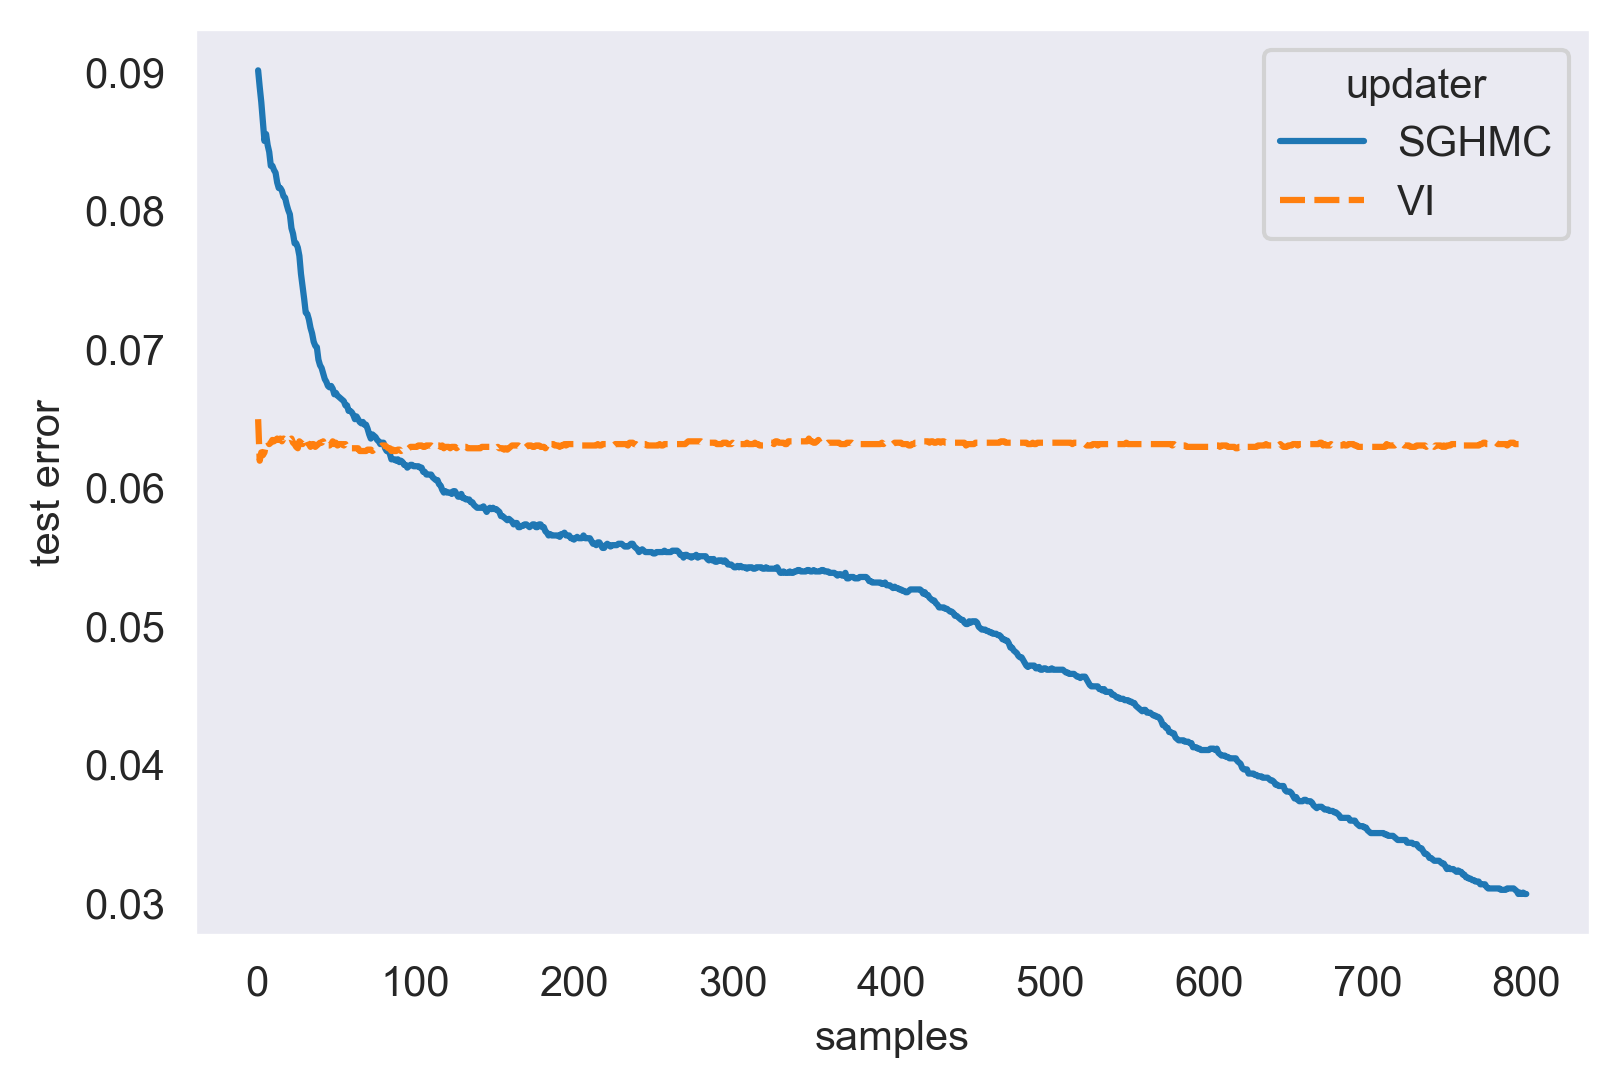

In [10]:
sns.set_style("dark")
    
sghmc_test_errs = np.array(sghmc_test_errs)
vi_test_errs = np.array(vi_test_errs)

err_dict = {'SGHMC' : sghmc_test_errs, 'VI' : vi_test_errs}
x = np.arange(1, NUM_EPOCHS+1)
lst = []
for i in range(len(x)):
    for updater in err_dict.keys():
        lst.append([x[i], updater, err_dict[updater][i]])

df = pd.DataFrame(lst, columns=['samples', 'updater','test error'])
sns.lineplot(data=df.pivot("samples", "updater", "test error"))
plt.ylabel("test error")
plt.show() #dpi=300